In [1]:
####ACTIVE CELL#### 
#Import
import tensorflow as tf
from tensorflow.python.keras import backend as K
import keras
from sklearn.preprocessing import StandardScaler

import numpy as np
import cv2 as cv
%matplotlib inline
import os
import re
import sys

#Importing project setup variables
from setup_project import *

#To run project notebooks in subfolders as from root folder
sys.path.append('../../' if SETUP_WORK_LOCAL else '../')

###Import self-written library
import featexlib
from featexlib import Debug as dbug
from featexlib import *

plt.style.use('seaborn-whitegrid')

#for autorealoading the submodules
%load_ext autoreload
%autoreload 2

In [2]:
####ACTIVE CELL#### 
#SHOW PROJECT SETUP
print("########Project setup#############")
print("SETUP_WORK_LOCAL",SETUP_WORK_LOCAL)
print("SETUP_PROJECT_NAME",SETUP_PROJECT_NAME)
print("SETUP_Y_IS_RGB",SETUP_Y_IS_RGB)
print("SETUP_NUM_OF_CLASSES",SETUP_NUM_OF_CLASSES)
print("SETUP_LIST_OF_CLASS_COLORS",SETUP_LIST_OF_CLASS_COLORS)
print("SETUP_LIST_OF_CLASS_INDEXES",SETUP_LIST_OF_CLASS_INDEXES)
print("SETUP_CV_READ_MODE",SETUP_CV_READ_MODE)
print("SETUP_BASE_DIR",SETUP_BASE_DIR)
print("SETUP_PRETRAINED_MODELS_DIR",SETUP_PRETRAINED_MODELS_DIR)

########Project setup#############
SETUP_WORK_LOCAL True
SETUP_PROJECT_NAME scrapid
SETUP_Y_IS_RGB False
SETUP_NUM_OF_CLASSES 11
SETUP_LIST_OF_CLASS_COLORS [0, 8388608, 32768, 8421376, 128, 8388736, 32896, 8421504, 4194304, 12582912, 4227072]
SETUP_LIST_OF_CLASS_INDEXES [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
SETUP_CV_READ_MODE -1
SETUP_BASE_DIR ../../data/scrapid/
SETUP_PRETRAINED_MODELS_DIR ../../data/_pretrained_models/


In [75]:
###ACTIVE CELL###
#MAKING Scaler, weight analyze
dataset_dir = SETUP_BASE_DIR + "data_preprocess/"
dataset_name = "scrapid_11c_256x256_819_1" #Data set wich is used to make a scaler
scaler_dir = SETUP_BASE_DIR + 'models/scalers/' 
scaler_name = 'scrapid_11c_256x256_819_1_unet_scaler_v1' 
num_pics_for_scaler = None

def training_preprocessor(n_train=None, 
                         dataset_dir = "", 
                         dataset_name="", 
                         dataset_path = None, 
                         scaler_dir='', 
                         scaler_name='scaler', 
                         scaler_path=None,
                         weight_calc=True,
                         load_extra=False):

    x_load, y_load = None,None
    
    if load_extra:
        x_load, y_load, _ = Image_generator.load_data(save_dir = dataset_dir, name=dataset_name, path=dataset_path)
    else:
        x_load, y_load = Image_generator.load_data(save_dir = dataset_dir, name=dataset_name, path=dataset_path)

    if n_train is not None:
        x_load = x_load[:n_train]
        y_load = y_load[:n_train]

    #Balance calcualation
    if weight_calc:
        #balance_table = np.array([np.mean(np.argmax(y_load, axis=-1) == c) for c in range(y_load.shape[-1])])
        balance_table = np.array([np.mean(np.argmax(y_load, axis=-1) == c) for c in SETUP_LIST_OF_CLASS_INDEXES])
        print('Class balance:')
        print(balance_table)
        
    #Scaler    
    scaler = StandardScaler()
    
    print('Fitting scaler on dataset with shape',x_load.shape)
    print('Mean before scaler',x_load.mean())
    
    x_train_sc = scaler.fit_transform(x_load.reshape(x_load.shape[0],-1))
    
    print('Mean value after scaler',x_train_sc.mean())
    
    scaler_path = scaler_path if scaler_path is not None else os.path.join(scaler_dir, "%s.pkl"%(scaler_name))
    
    print('Scaler exported to',scaler_path)
    
    pickle.dump(scaler, open(scaler_path,'wb'))

    
training_preprocessor (n_train=num_pics_for_scaler, 
                             dataset_dir = dataset_dir, 
                             dataset_name = dataset_name, 
                             scaler_dir = scaler_dir, 
                             scaler_name = scaler_name
                     )


Class balance:
[0.66342338 0.00351992 0.00403026 0.00303342 0.0020509  0.0021129
 0.00169319 0.00178381 0.00186012 0.00149286 0.00129254]
Fitting scaler on dataset with shape (819, 256, 256, 3)
Mean before scaler 93.7990643350293
Mean value after scaler 1.4436966071132988e-16
Scaler exported to ../../data/scrapid/models/scalers/scrapid_11c_256x256_819_1_unet_scaler_v1.pkl


In [16]:
###ACTIVE CELL#####
#Traning setup
batch_size = 16     
epochs=1
steps_per_epoch = 4
shuffle = False

model_checkpoint = SETUP_BASE_DIR + 'models/checkpoints/scrapid_11c_256x256_unet_cpu.h5'
save_model = SETUP_BASE_DIR + 'models/scrapid_11c_256x256_unet_gpu'
#data_dir = SETUP_BASE_DIR + "data_debug/"
data_dir = SETUP_BASE_DIR + "data_validation/"
#data_dir = SETUP_BASE_DIR + "data_training/"
scaler_file = SETUP_BASE_DIR + 'models/scalers/scrapid_11c_256x256_819_1_unet_scaler_v1.pkl'

###Enter custom balance table if you want:
balance_table = np.array([10, 0, 2, 1.8, 1, 1, 1, 1, 1, 1, 1])
#################################################

###Help function that normalizes weight coefficients
def get_balanced_weight(inp, norm=False):
    norm_inp =  inp/inp.sum()
    
    num_classes = len(inp)
    
    ideal = 1/num_classes
    
    k_arr = np.array([(ideal/i) if i != 0 else 0 for i in norm_inp] )
    
    if norm:
        return k_arr/k_arr.sum()
    else:
        return k_arr

class_weights = get_balanced_weight(balance_table)

print('Weight table:')
print(class_weights)

Weight table:
[0.18909091 0.         0.94545455 1.05050505 1.89090909 1.89090909
 1.89090909 1.89090909 1.89090909 1.89090909 1.89090909]


In [5]:
###ACTIVE CELL###
#Creating DataGenerator for training dataset
#DataGenerator class definition
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data_dir="../../data/", preprocess_pipeline=None, batch_size=32, steps_per_epoch=steps_per_epoch, file_filter_regex = r'/([^/]+)\.npy', recursive=True):
        
        self.last_data = False
        self.last_item = False
        
        def get_data_file(arr):
            while True:
                for i,v in enumerate(arr):
                    self.last_data = (i==len(arr)-1)
                    yield v 
        
        self.file_list = [f for f in glob.glob(f"{data_dir}/**", recursive=recursive) if os.path.isfile(f) and re.search(file_filter_regex, f)]
        self.actual_data_file_path = get_data_file(self.file_list)
        self.actual_data_set = None
        self.batch_size = batch_size
        self.steps_per_epoch = steps_per_epoch
        self.num_batches = None
        self.data_len = None
        self.preprocess_pipeline = preprocess_pipeline
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(self.data_len / self.batch_size)) if self.steps_per_epoch<=self.num_batches else self.steps_per_epoch

    def __getitem__(self, index):
        index_c = index%self.num_batches
        self.last_item = self.last_data and index_c == self.num_batches-1
        return self.x[index_c*self.batch_size:(index_c+1)*self.batch_size], self.y[index_c*self.batch_size:(index_c+1)*self.batch_size]

    def on_epoch_end(self):
        actual_data_file_path = self.actual_data_file_path.__next__()
        self.x, self.y = Image_generator.load_data(path = actual_data_file_path)
        self.data_len = len(self.x)
        
        self.num_batches = int(np.floor(self.data_len / self.batch_size))
        
        if self.preprocess_pipeline is not None:
            self.x, self.y = self.preprocess_pipeline(self.x, self.y)   
            
#Creating DataGenerator object    
data = DataGenerator(data_dir=data_dir,
                     batch_size = batch_size,
                     preprocess_pipeline = Image_generator(
                        Image_generator.Pipeline_x_y_images(
                            common_layers = [
                                Image_generator.Mod_scaler(file=scaler_file, target="x"),
                                Image_generator.Mod_astype('float32'),
                                #Image_generator.Mod_duplicate(num=1)
                                #Image_generator.Mod_reshape(shape=(-1,256,256,3),target="x"),
                            ],
                            special_layers = [[
                                #Image_generator.Mod_shuffle(),
                                #Image_generator.Mod_shift(sh_h=100, sh_v=100, rand = True, interpolation_saved = cv.INTER_NEAREST, borderValue=0, borderValue_saved=0),
                                #Image_generator.Mod_rotate(angle=180, rand = True, interpolation_saved = cv.INTER_NEAREST, borderValue=0, borderValue_saved=0),
                                Image_generator.Mod_one_hot( SETUP_LIST_OF_CLASS_INDEXES, rgb_mode = SETUP_Y_IS_RGB, target="y"),
                                Image_generator.Mod_merge_void(channel_num=0, target="y")
                            ]]
                        )
                    )
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3


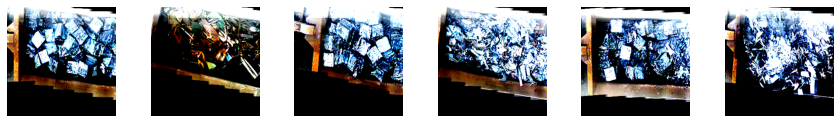

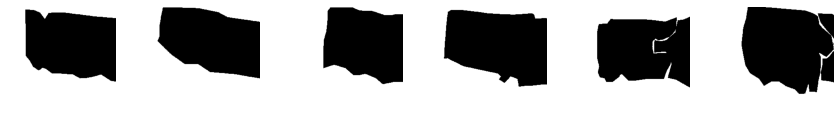

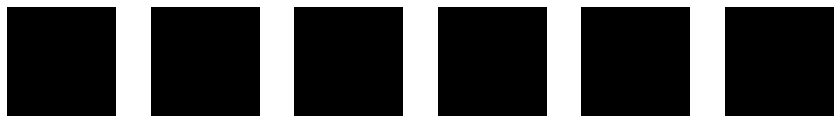

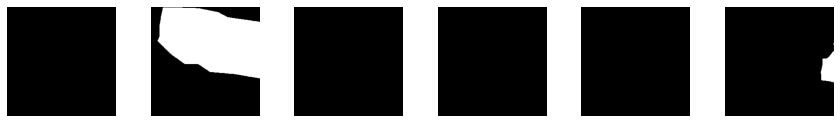

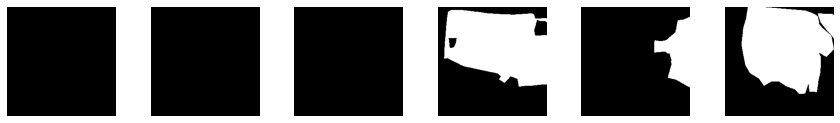

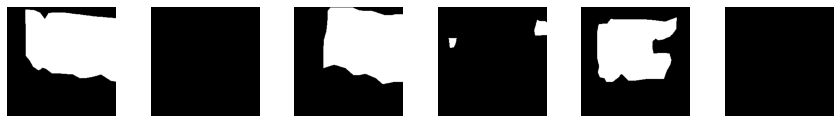

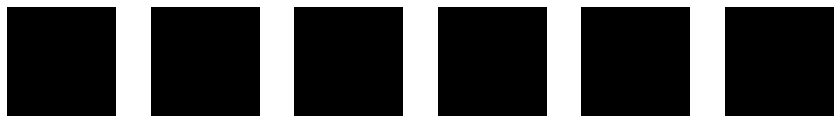

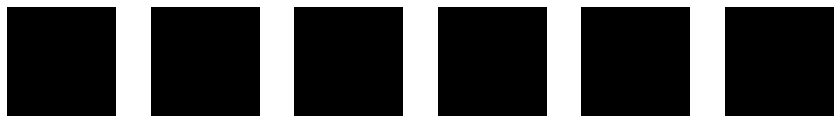

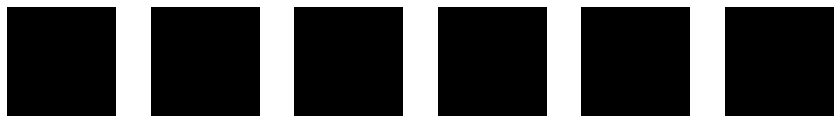

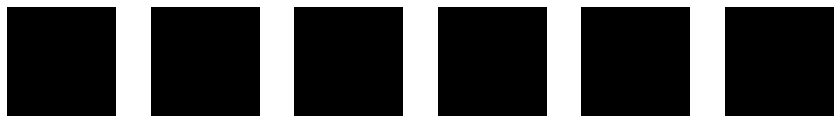

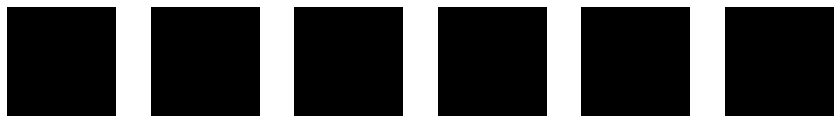

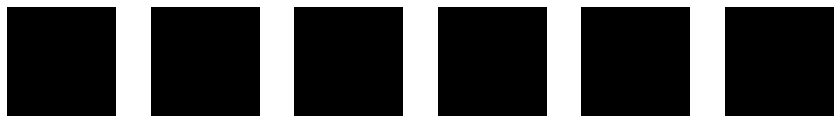

In [6]:
###DEBUG CELL####
#Take a look how our datset look like
#data.on_epoch_end()
print(data.num_batches)

tmp_x, tmp_y = data.__getitem__(0)

dbug.show_images_list(tmp_x[:6,...], col_number = 6)
for c in range(tmp_y.shape[-1]):
        dbug.show_images_list(tmp_y[:6,..., c], col_number = 6)

In [7]:
###ACTIVE CELL####
#Model transfer-learned VGG16
#TODO: pack to the module
K.clear_session()
def unet(pretrained_weights = None,input_size = SETUP_MODEL_INPUT_SHAPE, full_train=False):
    VGG16_weight = SETUP_PRETRAINED_MODELS_DIR + "vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
    VGG16 = tf.keras.applications.VGG16(include_top=False, weights=VGG16_weight, input_shape=input_size)
    last_layer = VGG16.output
    for layer in VGG16.layers:
        if layer.name in ['block1_conv1']:
            set_trainable = True
        if layer.name in ['block1_pool','block2_pool','block3_pool','block4_pool','block5_pool']:
            layer.trainable = full_train
            
    model_ = tf.keras.layers.Conv2DTranspose(256,(3,3),strides=(2, 2), padding='same')(last_layer)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_)    
    
    concat_1 = tf.keras.layers.concatenate([model_,VGG16.get_layer("block5_conv3").output])
    
    model_ = tf.keras.layers.Conv2D(512,(3,3),strides=(1, 1), padding='same')(concat_1)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_)
    
    model_ = tf.keras.layers.Conv2DTranspose(512,(3,3),strides=(2, 2),padding='same')(model_)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_) 
    
    concat_2 = tf.keras.layers.concatenate([model_,VGG16.get_layer("block4_conv3").output])
    
    model_ = tf.keras.layers.Conv2D(512,(3,3),strides=(1, 1), padding='same')(concat_2)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_)
    
    model_ = tf.keras.layers.Conv2DTranspose(512,(3,3),strides=(2, 2), padding='same')(model_)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_) 
    
    concat_3 = tf.keras.layers.concatenate([model_,VGG16.get_layer("block3_conv3").output])
    
    model_ = tf.keras.layers.Conv2D(256,(3,3),strides=(1, 1), padding='same')(concat_3)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_)
    
    model_ = tf.keras.layers.Conv2DTranspose(256,(3,3),strides=(2, 2),padding='same')(model_)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_) 
    
    concat_4 = tf.keras.layers.concatenate([model_,VGG16.get_layer("block2_conv2").output])
    
    model_ = tf.keras.layers.Conv2D(128,(3,3),strides=(1, 1), padding='same')(concat_4)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_)
    
    model_ = tf.keras.layers.Conv2DTranspose(128,(3,3),strides=(2, 2),padding='same')(model_)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_) 
    
    concat_5 = tf.keras.layers.concatenate([model_,VGG16.get_layer("block1_conv2").output])
    
    model_ = tf.keras.layers.Conv2D(64,(3,3),strides=(1, 1), padding='same')(concat_5)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_)
    
    model_ = tf.keras.layers.Conv2D(32,(3,3),strides=(1, 1), padding='same')(model_)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_)
    
    model_ = tf.keras.layers.Conv2D(SETUP_NUM_OF_CLASSES,(3,3),strides=(1, 1),padding='same')(model_)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_)
    #model_ = tf.keras.layers.Softmax()(model_)

    model_ = tf.keras.Model(VGG16.input,model_)
    
    model_.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-4), loss=weightedLoss(tf.keras.losses.CategoricalHinge(), class_weights), metrics=[Mean_IOU_tensorflow_2])
    #model_.compile(optimizer='sgd', loss=weightedLoss(tf.keras.losses.MeanSquaredError(), class_weights), metrics=[Mean_IOU_tensorflow_2])
    #model_.compile(optimizer='sgd', loss=tf.keras.losses.MeanSquaredError(), metrics=[Mean_IOU_tensorflow_2])
    
    #model_.compile(optimizer ='sgd', loss = 'categorical_hinge', metrics = [Mean_IOU_tensorflow_2])
    #model_.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-4), loss = 'categorical_hinge', metrics = ['accuracy'])
    #model_.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    if(pretrained_weights):
        model_.load_weights(pretrained_weights)
    
    return model_

def Mean_IOU_tensorflow_2(y_true, y_pred):
    nb_classes = K.int_shape(y_pred)[-1]
    iou = []
    true_pixels = K.argmax(y_true, axis=-1)
    pred_pixels = K.argmax(y_pred, axis=-1)
    void_labels = K.equal(K.sum(y_true, axis=-1), 0)
    for i in range(0, nb_classes): # exclude first label (background) and last label (void)
        true_labels = K.equal(true_pixels, i) & ~void_labels
        pred_labels = K.equal(pred_pixels, i) & ~void_labels
        inter = tf.cast(true_labels & pred_labels, tf.int32)
        union = tf.cast(true_labels | pred_labels, tf.int32)
        legal_batches = K.sum(tf.cast(true_labels, tf.int32), axis=1)>0
        ious = K.sum(inter, axis=1)/K.sum(union, axis=1)
        iou.append(K.mean(ious[legal_batches]))
    iou = tf.stack(iou)
    legal_labels = ~tf.math.is_nan(iou)
    iou = iou[legal_labels]
    return K.mean(iou)


def weightedLoss(originalLossFunc, weightsList):

    def lossFunc(true, pred):

        axis = -1 #if channels last 
        #axis=  1 #if channels first

        #argmax returns the index of the element with the greatest value
        #done in the class axis, it returns the class index    
        classSelectors = K.cast(K.argmax(true, axis=axis), tf.int32) 
            #if your loss is sparse, use only true as classSelectors

        #considering weights are ordered by class, for each class
        #true(1) if the class index is equal to the weight index   
        classSelectors = [K.equal(i, classSelectors) for i in range(len(weightsList))]

        #casting boolean to float for calculations  
        #each tensor in the list contains 1 where ground true class is equal to its index 
        #if you sum all these, you will get a tensor full of ones. 
        classSelectors = [K.cast(x, K.floatx()) for x in classSelectors]

        #for each of the selections above, multiply their respective weight
        weights = [sel * w for sel,w in zip(classSelectors, weightsList)] 

        #sums all the selections
        #result is a tensor with the respective weight for each element in predictions
        weightMultiplier = weights[0]
        for i in range(1, len(weights)):
            weightMultiplier = weightMultiplier + weights[i]


        #make sure your originalLossFunc only collapses the class axis
        #you need the other axes intact to multiply the weights tensor
        loss = originalLossFunc(true,pred) 
        loss = loss * weightMultiplier

        return loss
    return lossFunc

In [8]:
####ACTIVE CELL#####
#Compiling the model
model = unet()
if os.path.isfile(save_model + '.index') :
    print('Found pretrained data in', save_model)
    model.load_weights(save_model)
model.summary()

/home/tun/.virtualenvs/ml/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Found pretrained data in ../../data/scrapid/models/scrapid_11c_256x256_unet_gpu
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 256, 64  36928       ['block1_conv1[0][0]']           
              

In [8]:
####ACTIVE CELL#####
#Initialise checkpointer
checkpointer = tf.keras.callbacks.ModelCheckpoint(model_checkpoint, verbose=1, mode='auto', monitor='loss', save_best_only=True)

In [9]:
####ACTIVE CELL#####
model.fit(data, batch_size=batch_size, epochs=epochs, steps_per_epoch = steps_per_epoch, callbacks=[checkpointer], shuffle=shuffle)

4/4 [==============================] - ETA: 0s - loss: 0.1310 - Mean_IOU_tensorflow_2: 0.5280 
Epoch 00001: loss improved from inf to 0.13103, saving model to ../../data/scrapid/models/checkpoints/scrapid_11c_256x256_unet_cpu.h5
4/4 [==============================] - 154s 39s/step - loss: 0.1310 - Mean_IOU_tensorflow_2: 0.5280


In [14]:
####ACTIVE CELL#####
###Save model after training
model.save_weights(save_model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


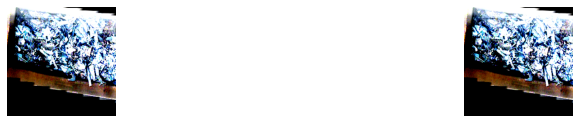

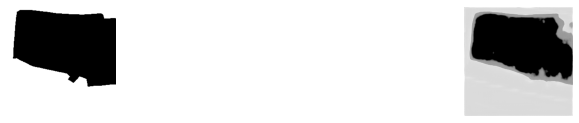

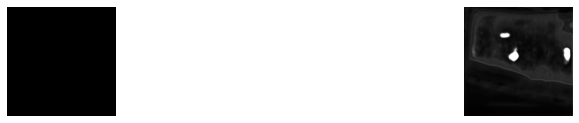

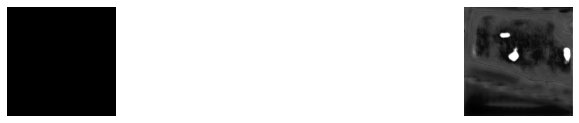

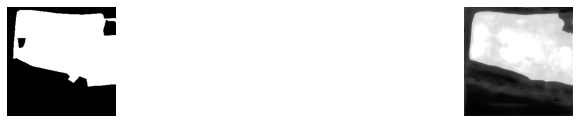

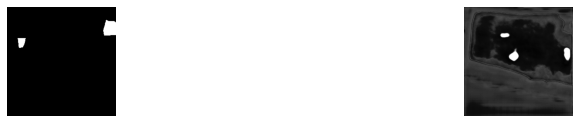

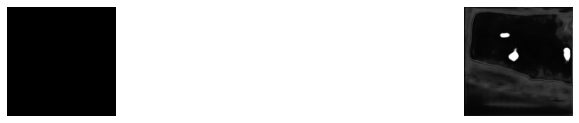

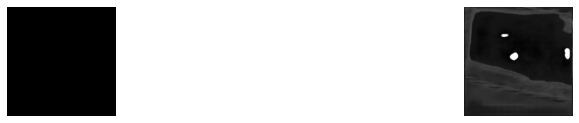

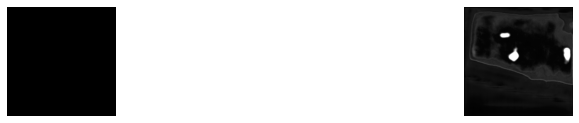

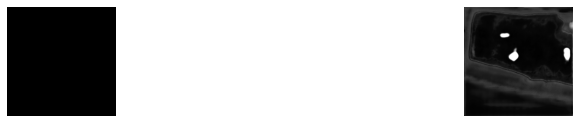

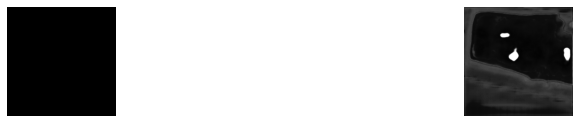

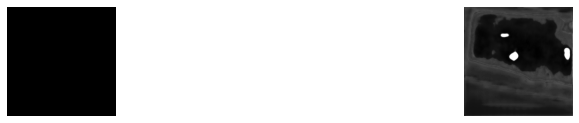

In [10]:
###ANALYSE CELL####
#Helpful function
#Show prediction result over the image
batch_num = 0
num_in_batch = 3
x_, y_ = data.__getitem__(batch_num)

def show_predict_one_by_class(x,x_orig,y_orig, model):
    model_shape= np.array(model.input_shape)
    model_shape[model_shape==None]=-1
    x = x.reshape(model_shape)
    x_orig = x_orig.reshape(model_shape)
    x_shape = x.shape
    y_pred = model(x).numpy()
    y_pred = (np.clip(((y_pred - y_pred.mean() + y_pred.std())/y_pred.std())*127, 0,255)).astype('int16')
    
    dbug.show_images_list(np.concatenate([x,x_orig], axis=0), col_number = 2)
    for c in range(y_orig.shape[-1]):
        dbug.show_images_list([y_orig[...,c].reshape(x_shape[1],x_shape[2],1), y_pred[...,c].reshape(x_shape[1],x_shape[2],1)], col_number = 2) 


show_predict_one_by_class(x_[num_in_batch],x_[num_in_batch],y_[num_in_batch],model)


In [9]:
###ANALYSE CELL####
#Helpful function
#Show prediction result over the whole batch 
def IOU_tensorflow_2(y_true, y_pred):
    nb_classes = K.int_shape(y_pred)[-1]
    iou = []
    true_pixels = K.argmax(y_true, axis=-1)
    pred_pixels = K.argmax(y_pred, axis=-1)
    void_labels = K.equal(K.sum(y_true, axis=-1), 0)
    for i in range(0, nb_classes): # exclude first label (background) and last label (void)
        true_labels = K.equal(true_pixels, i) & ~void_labels
        pred_labels = K.equal(pred_pixels, i) & ~void_labels
        inter = tf.cast(true_labels & pred_labels, tf.int32)
        union = tf.cast(true_labels | pred_labels, tf.int32)
        legal_batches = K.sum(tf.cast(true_labels, tf.int32), axis=1)>0
        ious = K.sum(inter, axis=1)/K.sum(union, axis=1)
        iou.append(K.mean(ious[legal_batches]))
    iou = tf.stack(iou)
    legal_labels = ~tf.math.is_nan(iou)
    #iou = iou[legal_labels]
    #return K.mean(iou)
    return iou.numpy()

def caclulate_IOU_on_dataset(data):
    for i in range(len(data.file_list)):
        result=[]
        for k in range(data.num_batches):
            x_, y_ = data.__getitem__(k)
            result.append([IOU_tensorflow_2(y_,model(x_).numpy())]) 
        if not data.last_data:
            data.on_epoch_end()
        
        result = np.concatenate(result, axis=0)
        
        return np.nanmean(result, axis=0)   

caclulate_IOU_on_dataset(data)

<ipython-input-9-4f454c5ff833>:35: RuntimeWarning: Mean of empty slice
  return np.nanmean(result, axis=0)


array([0.88801784,        nan, 0.58545337, 0.79303433, 0.65109364,
       0.03565703,        nan,        nan,        nan, 0.01893703,
       0.28220348])

1


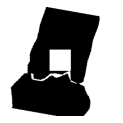

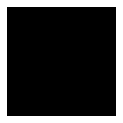

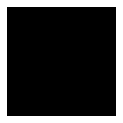

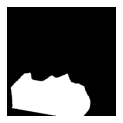

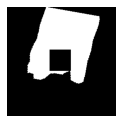

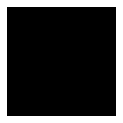

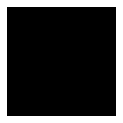

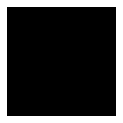

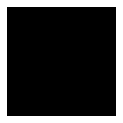

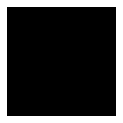

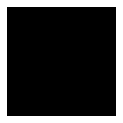

In [28]:
#####DEBUG CELL#####
_x,_y = data.__getitem__(5)

_y[:,100:150,100:150,:]=0

true_pixels = np.equal(np.sum(_y, axis=-1), 0).astype(_y.dtype)#K.equal(K.sum(_y, axis=-1), 0).numpy()

_y[...,0] = _y[...,0] + true_pixels

print(true_pixels.max())
#true_pixels.max()
for c in range(_y.shape[-1]):
    dbug.show_images_list(_y[0,...,c].reshape(-1,_y.shape[1],_y.shape[2]),col_number = 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

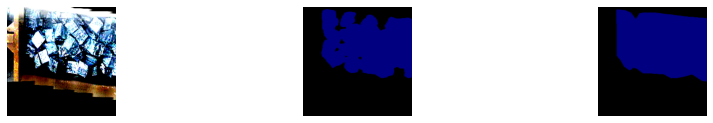

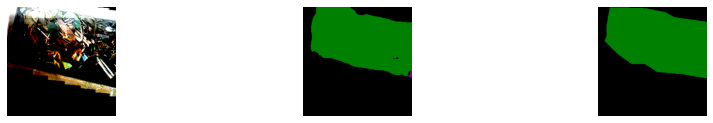

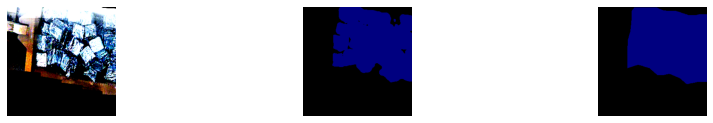

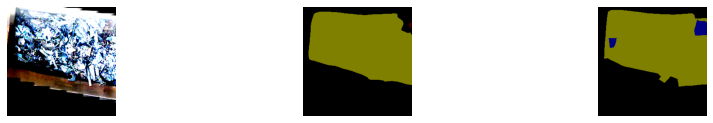

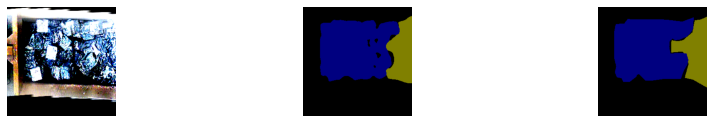

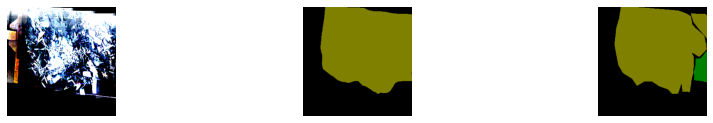

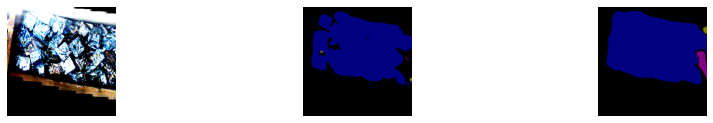

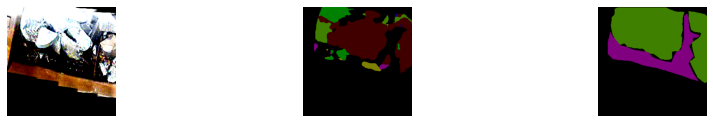

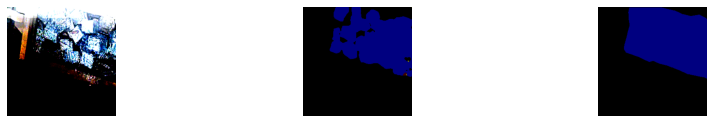

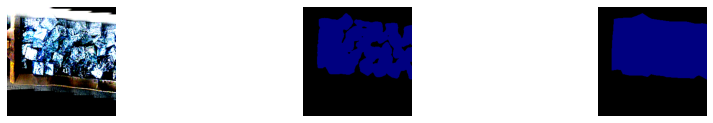

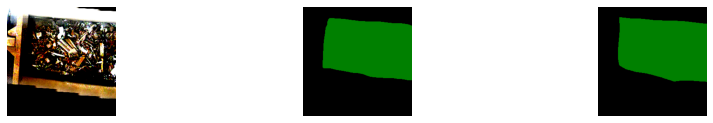

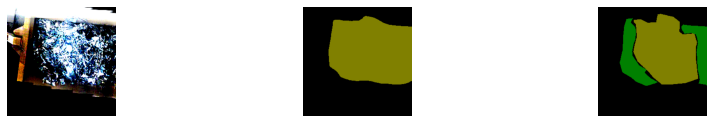

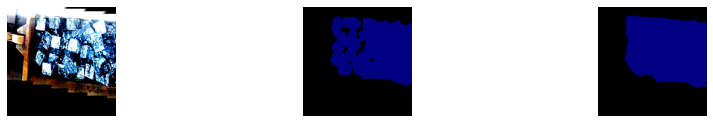

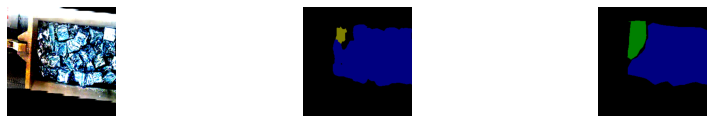

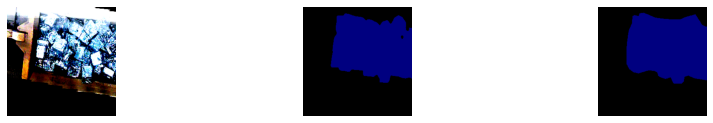

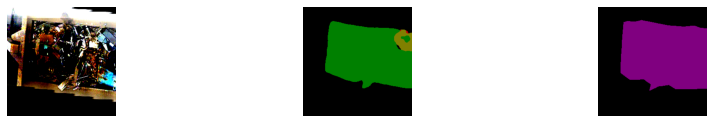

In [11]:
###ANALYSE CELL####
#Helpful function
#Show prediction result over the whole batch 
batch_num = 0
x_, y_ = data.__getitem__(batch_num)

def show_predict_compare_batch_by_rgb(x,x_orig,y_orig,model,list_of_codes_colors = SETUP_LIST_OF_CLASS_COLORS):
    model_shape= np.array(model.input_shape)
    model_shape[model_shape==None]=-1
    x = x.reshape(model_shape)
    
    y_pred = model(x).numpy()

    y_orig = Image_generator.one_hot_to_rgb( y_orig, list_of_codes_colors = list_of_codes_colors)
    y_pred = Image_generator.one_hot_to_rgb( y_pred, list_of_codes_colors = list_of_codes_colors)
    
    for c in range(y_pred.shape[0]):
        dbug.show_images_list([x_orig[c,...],y_pred[c,...],y_orig[c,...]],col_number = 3)
        

show_predict_compare_batch_by_rgb(x_,x_,y_,model)    